In [1]:
import wrf
from wrf import getvar, ALL_TIMES, latlon_coords
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import datetime
from datetime import datetime, timedelta
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
from braceexpand import braceexpand
import pandas as pd
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'


### Set global variables
Anything that will be used throughout the script should be assigned here.

In [2]:
# Set the bounds you want to look at
lat_bound = [-5,5]		# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East
lat_avg_bound = [-5,5]

### Functions

In [3]:
def hov_diurnal(da, LT):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.XLAT>lat_avg_bound[0])&(da.XLAT<lat_avg_bound[1]),drop=True).mean(dim='south_north')

    if LT:
        # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
            # diurnal cycle of rain rate.
        array = np.zeros((da_avg.shape[1],24))
        # Loop through each longitude, look through all the timesteps and group them by hour,
            # and then average the values at each hour. Output the 1x24 array into the empty array
        for i in range(array.shape[0]):
            array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    else:
        array = da_avg.mean('west_east').groupby('XTIME.hour').mean()
    return array

In [4]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [5]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)
	local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.XTIME.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	return da

In [6]:
def da_info(da):
    print('Description: ', da.description, '\nUnits: ',da.units, '\nDimensions: ', da.dims, '\nShape: ', da.shape)

## Read in Datasets

#### Old control

In [16]:
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/6day-2015-11-22-12--28-12/'

# Point to the individual .nc files
file_d01_raw = parent_dir + 'raw/d01'
file_d02_raw = parent_dir + 'raw/d02'
file_d01_RR = parent_dir + 'L1/d01_RR'				# [mm/dt]
file_d02_RR = parent_dir + 'L1/d02_RR'				# [mm/dt]
file_d01_LWUPT = parent_dir + 'L1/d01_LWUPT'	    # [W/m^2]
file_d02_LWUPT = parent_dir + 'L1/d02_LWUPT'	    # [W/m^2]
file_d01_QV850 = parent_dir + 'L2/d01_interp_QV850'	# [kg/kg]
file_d02_QV850 = parent_dir + 'L2/d02_interp_QV850'	# [kg/kg]
file_d01_U850 = parent_dir + 'L2/d01_interp_U850'	# [m/s]
file_d02_U850 = parent_dir + 'L2/d02_interp_U850'	# [m/s]
file_d01_U200 = parent_dir + 'L2/d01_interp_U200'	# [m/s]
file_d02_U200 = parent_dir + 'L2/d02_interp_U200'	# [m/s]

# Raw datasets
start_time = time.perf_counter()
ds_d01 = xr.open_dataset(file_d01_raw)  # Used for .sel()
ds_d02 = xr.open_dataset(file_d02_raw)  # Used for .sel()
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    XTIME=('Time',ds_d01.XTIME.values)
    )
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    XTIME=('Time',ds_d02.XTIME.values)
    )
step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

# 850 hPa zonal winds
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_U850)
da_d01_U850_oldcntl = ds['U'].compute().squeeze()
da_d01_U850_oldcntl = da_d01_U850_oldcntl.assign_coords(d01_coords)
fill_value = da_d01_U850_oldcntl.max()      # This is the fill_value, meaning missing_data
da_d01_U850_oldcntl = da_d01_U850_oldcntl.where(da_d01_U850_oldcntl!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_U850)
da_d02_U850_oldcntl = ds['U'].compute().squeeze()
da_d02_U850_oldcntl = da_d02_U850_oldcntl.assign_coords(d02_coords)
da_d02_U850_oldcntl = da_d02_U850_oldcntl.where(da_d02_U850_oldcntl!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('850 hPa zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# 200 hPa zonal winds
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_U200)
da_d01_U200_oldcntl = ds['U'].compute().squeeze()
da_d01_U200_oldcntl = da_d01_U200_oldcntl.assign_coords(d01_coords)
fill_value = da_d01_U200_oldcntl.max()      # This is the fill_value meaning missing_data
da_d01_U200_oldcntl = da_d01_U200_oldcntl.where(da_d01_U200_oldcntl!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_U200)
da_d02_U200_oldcntl = ds['U'].compute().squeeze()
da_d02_U200_oldcntl = da_d02_U200_oldcntl.assign_coords(d02_coords)
da_d02_U200_oldcntl = da_d02_U200_oldcntl.where(da_d02_U200_oldcntl!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('200 hPa zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Rain Rate     [mm/hr]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_RR)
da_d01_RR_oldcntl = ds['RR'].compute()
da_d01_RR_oldcntl = da_d01_RR_oldcntl.assign_coords(d01_coords)
ds = xr.open_dataset(file_d02_RR)
da_d02_RR_oldcntl = ds['RR'].compute()
da_d02_RR_oldcntl = da_d02_RR_oldcntl.assign_coords(d02_coords)
step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Instantaneous Longwave Upwelling Flux at Top (LWUPT) [W/m^2]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_LWUPT)
da_d01_LWUPT_oldcntl = ds['LWUPT'].compute()
da_d01_LWUPT_oldcntl = da_d01_LWUPT_oldcntl.assign_coords(d01_coords)
ds = xr.open_dataset(file_d02_LWUPT)
da_d02_LWUPT_oldcntl = ds['LWUPT'].compute()
da_d02_LWUPT_oldcntl = da_d02_LWUPT_oldcntl.assign_coords(d02_coords)
step1_time = time.perf_counter()
print('Longwave Upwelling Flux at TOA loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Water vapor mixing ratio     [kg/kg]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_QV850)
da_d01_QV850_oldcntl = ds['QV'].compute().squeeze()
da_d01_QV850_oldcntl = da_d01_QV850_oldcntl.assign_coords(d01_coords)
fill_value = da_d01_QV850_oldcntl.max()      # This is the fill_value, meaning missing_data
da_d01_QV850_oldcntl = da_d01_QV850_oldcntl.where(da_d01_QV850_oldcntl!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_QV850)
da_d02_QV850_oldcntl = ds['QV'].compute().squeeze()
da_d02_QV850_oldcntl = da_d02_QV850_oldcntl.assign_coords(d02_coords)
fill_value = da_d02_QV850_oldcntl.max()      # This is the fill_value, meaning missing_data
da_d02_QV850_oldcntl = da_d02_QV850_oldcntl.where(da_d02_QV850_oldcntl!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('850 hPa Water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Detection of land & water
step2_time = time.perf_counter()
da_d01_LANDMASK = ds_d01['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
step1_time = time.perf_counter()
print('Landmask loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Temporal and Spatial variables
step2_time = time.perf_counter()
da_d01_XTIME = da_d01_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d02_XTIME = da_d02_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d01_LATS, da_d01_LONGS = wrf.latlon_coords(da_d01_LANDMASK)	# Lat & Lon [degrees]
da_d02_LATS, da_d02_LONGS = wrf.latlon_coords(da_d02_LANDMASK)	# Lat & Lon [degrees]
step1_time = time.perf_counter()
print('Tempospatial variables loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

Dataset loaded ✓ 1.7100338640157133 seconds
Created coordinate dictionaries ✓ 3.9808443010551855 seconds
850 hPa zonal winds loaded ✓ 1.3666681569302455 seconds
200 hPa zonal winds loaded ✓ 1.3611710369586945 seconds
Rain rates loaded ✓ 0.5420650509186089 seconds
Longwave Upwelling Flux at TOA loaded ✓ 0.5352292340248823 seconds
850 hPa Water vapor mixing ratio loaded ✓ 1.5475355229573324 seconds
Landmask loaded ✓ 0.014984461013227701 seconds
Tempospatial variables loaded ✓ 0.00029048090800642967 seconds
Domain d01 & d02 ✓ 11.060027692001313 seconds


#### New Control

In [17]:
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/36hour-2015-11-22-12--24-00/'

# Point to the individual .nc files
file_d01_raw = parent_dir + 'raw.cntl/d01'
file_d02_raw = parent_dir + 'raw.cntl/d02'
file_d01_RR = parent_dir + 'L1.cntl/d01_RR'				# [mm/dt]
file_d02_RR = parent_dir + 'L1.cntl/d02_RR'				# [mm/dt]
file_d01_LWUPT = parent_dir + 'L1.cntl/d01_LWUPT'	    # [W/m^2]
file_d02_LWUPT = parent_dir + 'L1.cntl/d02_LWUPT'	    # [W/m^2]
file_d01_QV850 = parent_dir + 'L2.cntl/d01_interp_QV850'	# [kg/kg]
file_d02_QV850 = parent_dir + 'L2.cntl/d02_interp_QV850'	# [kg/kg]
file_d01_U850 = parent_dir + 'L2.cntl/d01_interp_U850'	# [m/s]
file_d02_U850 = parent_dir + 'L2.cntl/d02_interp_U850'	# [m/s]
file_d01_U200 = parent_dir + 'L2.cntl/d01_interp_U200'	# [m/s]
file_d02_U200 = parent_dir + 'L2.cntl/d02_interp_U200'	# [m/s]

# Raw datasets
start_time = time.perf_counter()
ds_d01 = xr.open_dataset(file_d01_raw)  # Used for .sel()
ds_d02 = xr.open_dataset(file_d02_raw)  # Used for .sel()
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    XTIME=('Time',ds_d01.XTIME.values)
    )
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    XTIME=('Time',ds_d02.XTIME.values)
    )
step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

# 850 hPa zonal winds
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_U850)
da_d01_U850_cntl = ds['U'].compute().squeeze()
da_d01_U850_cntl = da_d01_U850_cntl.assign_coords(d01_coords)
fill_value = da_d01_U850_cntl.max()      # This is the fill_value, meaning missing_data
da_d01_U850_cntl = da_d01_U850_cntl.where(da_d01_U850_cntl!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_U850)
da_d02_U850_cntl = ds['U'].compute().squeeze()
da_d02_U850_cntl = da_d02_U850_cntl.assign_coords(d02_coords)
da_d02_U850_cntl = da_d02_U850_cntl.where(da_d02_U850_cntl!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('850 hPa zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# 200 hPa zonal winds
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_U200)
da_d01_U200_cntl = ds['U'].compute().squeeze()
da_d01_U200_cntl = da_d01_U200_cntl.assign_coords(d01_coords)
fill_value = da_d01_U200_cntl.max()      # This is the fill_value meaning missing_data
da_d01_U200_cntl = da_d01_U200_cntl.where(da_d01_U200_cntl!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_U200)
da_d02_U200_cntl = ds['U'].compute().squeeze()
da_d02_U200_cntl = da_d02_U200_cntl.assign_coords(d02_coords)
da_d02_U200_cntl = da_d02_U200_cntl.where(da_d02_U200_cntl!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('200 hPa zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Rain Rate     [mm/hr]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_RR)
da_d01_RR_cntl = ds['RR'].compute()
da_d01_RR_cntl = da_d01_RR_cntl.assign_coords(d01_coords)
ds = xr.open_dataset(file_d02_RR)
da_d02_RR_cntl = ds['RR'].compute()
da_d02_RR_cntl = da_d02_RR_cntl.assign_coords(d02_coords)
step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Instantaneous Longwave Upwelling Flux at Top (LWUPT) [W/m^2]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_LWUPT)
da_d01_LWUPT_cntl = ds['LWUPT'].compute()
da_d01_LWUPT_cntl = da_d01_LWUPT_cntl.assign_coords(d01_coords)
ds = xr.open_dataset(file_d02_LWUPT)
da_d02_LWUPT_cntl = ds['LWUPT'].compute()
da_d02_LWUPT_cntl = da_d02_LWUPT_cntl.assign_coords(d02_coords)
step1_time = time.perf_counter()
print('Longwave Upwelling Flux at TOA loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Water vapor mixing ratio     [kg/kg]
step2_time = time.perf_counter()
ds = xr.open_dataset(file_d01_QV850)
da_d01_QV850_cntl = ds['QV'].compute().squeeze()
da_d01_QV850_cntl = da_d01_QV850_cntl.assign_coords(d01_coords)
fill_value = da_d01_QV850_cntl.max()      # This is the fill_value, meaning missing_data
da_d01_QV850_cntl = da_d01_QV850_cntl.where(da_d01_QV850_cntl!=fill_value)    # Change fill_value points to nans
ds = xr.open_dataset(file_d02_QV850)
da_d02_QV850_cntl = ds['QV'].compute().squeeze()
da_d02_QV850_cntl = da_d02_QV850_cntl.assign_coords(d02_coords)
fill_value = da_d02_QV850_cntl.max()      # This is the fill_value, meaning missing_data
da_d02_QV850_cntl = da_d02_QV850_cntl.where(da_d02_QV850_cntl!=fill_value)    # Change fill_value points to nans
step1_time = time.perf_counter()
print('850 hPa Water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Detection of land & water
step2_time = time.perf_counter()
da_d01_LANDMASK = ds_d01['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
step1_time = time.perf_counter()
print('Landmask loaded \N{check mark}', step1_time-step2_time, 'seconds')

# Temporal and Spatial variables
step2_time = time.perf_counter()
da_d01_XTIME = da_d01_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d02_XTIME = da_d02_LANDMASK.XTIME						# Times in datetime64 [hourly]
da_d01_LATS, da_d01_LONGS = wrf.latlon_coords(da_d01_LANDMASK)	# Lat & Lon [degrees]
da_d02_LATS, da_d02_LONGS = wrf.latlon_coords(da_d02_LANDMASK)	# Lat & Lon [degrees]
step1_time = time.perf_counter()
print('Tempospatial variables loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

Dataset loaded ✓ 1.65984544204548 seconds
Created coordinate dictionaries ✓ 1.1666385550051928 seconds
850 hPa zonal winds loaded ✓ 0.403852308052592 seconds
200 hPa zonal winds loaded ✓ 0.3923838760238141 seconds
Rain rates loaded ✓ 0.1672301769722253 seconds
Longwave Upwelling Flux at TOA loaded ✓ 0.17129103699699044 seconds
850 hPa Water vapor mixing ratio loaded ✓ 0.4183945059776306 seconds
Landmask loaded ✓ 0.018689075019210577 seconds
Tempospatial variables loaded ✓ 0.00036055000964552164 seconds
Domain d01 & d02 ✓ 4.399909602012485 seconds


#### RRMTG-K Scheme

#### Add Local Time Coordinate

In [18]:
## d01
# Old Control
da_d01_U850_oldcntl = assign_LT_coord(da_d01_U850_oldcntl)
da_d01_U200_oldcntl = assign_LT_coord(da_d01_U200_oldcntl)
da_d01_RR_oldcntl = assign_LT_coord(da_d01_RR_oldcntl)
da_d01_LWUPT_oldcntl = assign_LT_coord(da_d01_LWUPT_oldcntl)
da_d01_QV850_oldcntl = assign_LT_coord(da_d01_QV850_oldcntl)
# Control
da_d01_U850_cntl = assign_LT_coord(da_d01_U850_cntl)
da_d01_U200_cntl = assign_LT_coord(da_d01_U200_cntl)
da_d01_RR_cntl = assign_LT_coord(da_d01_RR_cntl)
da_d01_LWUPT_cntl = assign_LT_coord(da_d01_LWUPT_cntl)
da_d01_QV850_cntl = assign_LT_coord(da_d01_QV850_cntl)

## d02
# Old Control
da_d02_U850_oldcntl = assign_LT_coord(da_d02_U850_oldcntl)
da_d02_U200_oldcntl = assign_LT_coord(da_d02_U200_oldcntl)
da_d02_RR_oldcntl = assign_LT_coord(da_d02_RR_oldcntl)
da_d02_LWUPT_oldcntl = assign_LT_coord(da_d02_LWUPT_oldcntl)
da_d02_QV850_oldcntl = assign_LT_coord(da_d02_QV850_oldcntl)
# Control
da_d02_U850_cntl = assign_LT_coord(da_d02_U850_cntl)
da_d02_U200_cntl = assign_LT_coord(da_d02_U200_cntl)
da_d02_RR_cntl = assign_LT_coord(da_d02_RR_cntl)
da_d02_LWUPT_cntl = assign_LT_coord(da_d02_LWUPT_cntl)
da_d02_QV850_cntl = assign_LT_coord(da_d02_QV850_cntl)

## Diagnostics

### Hovmollers

Text(0, 0.5, '')

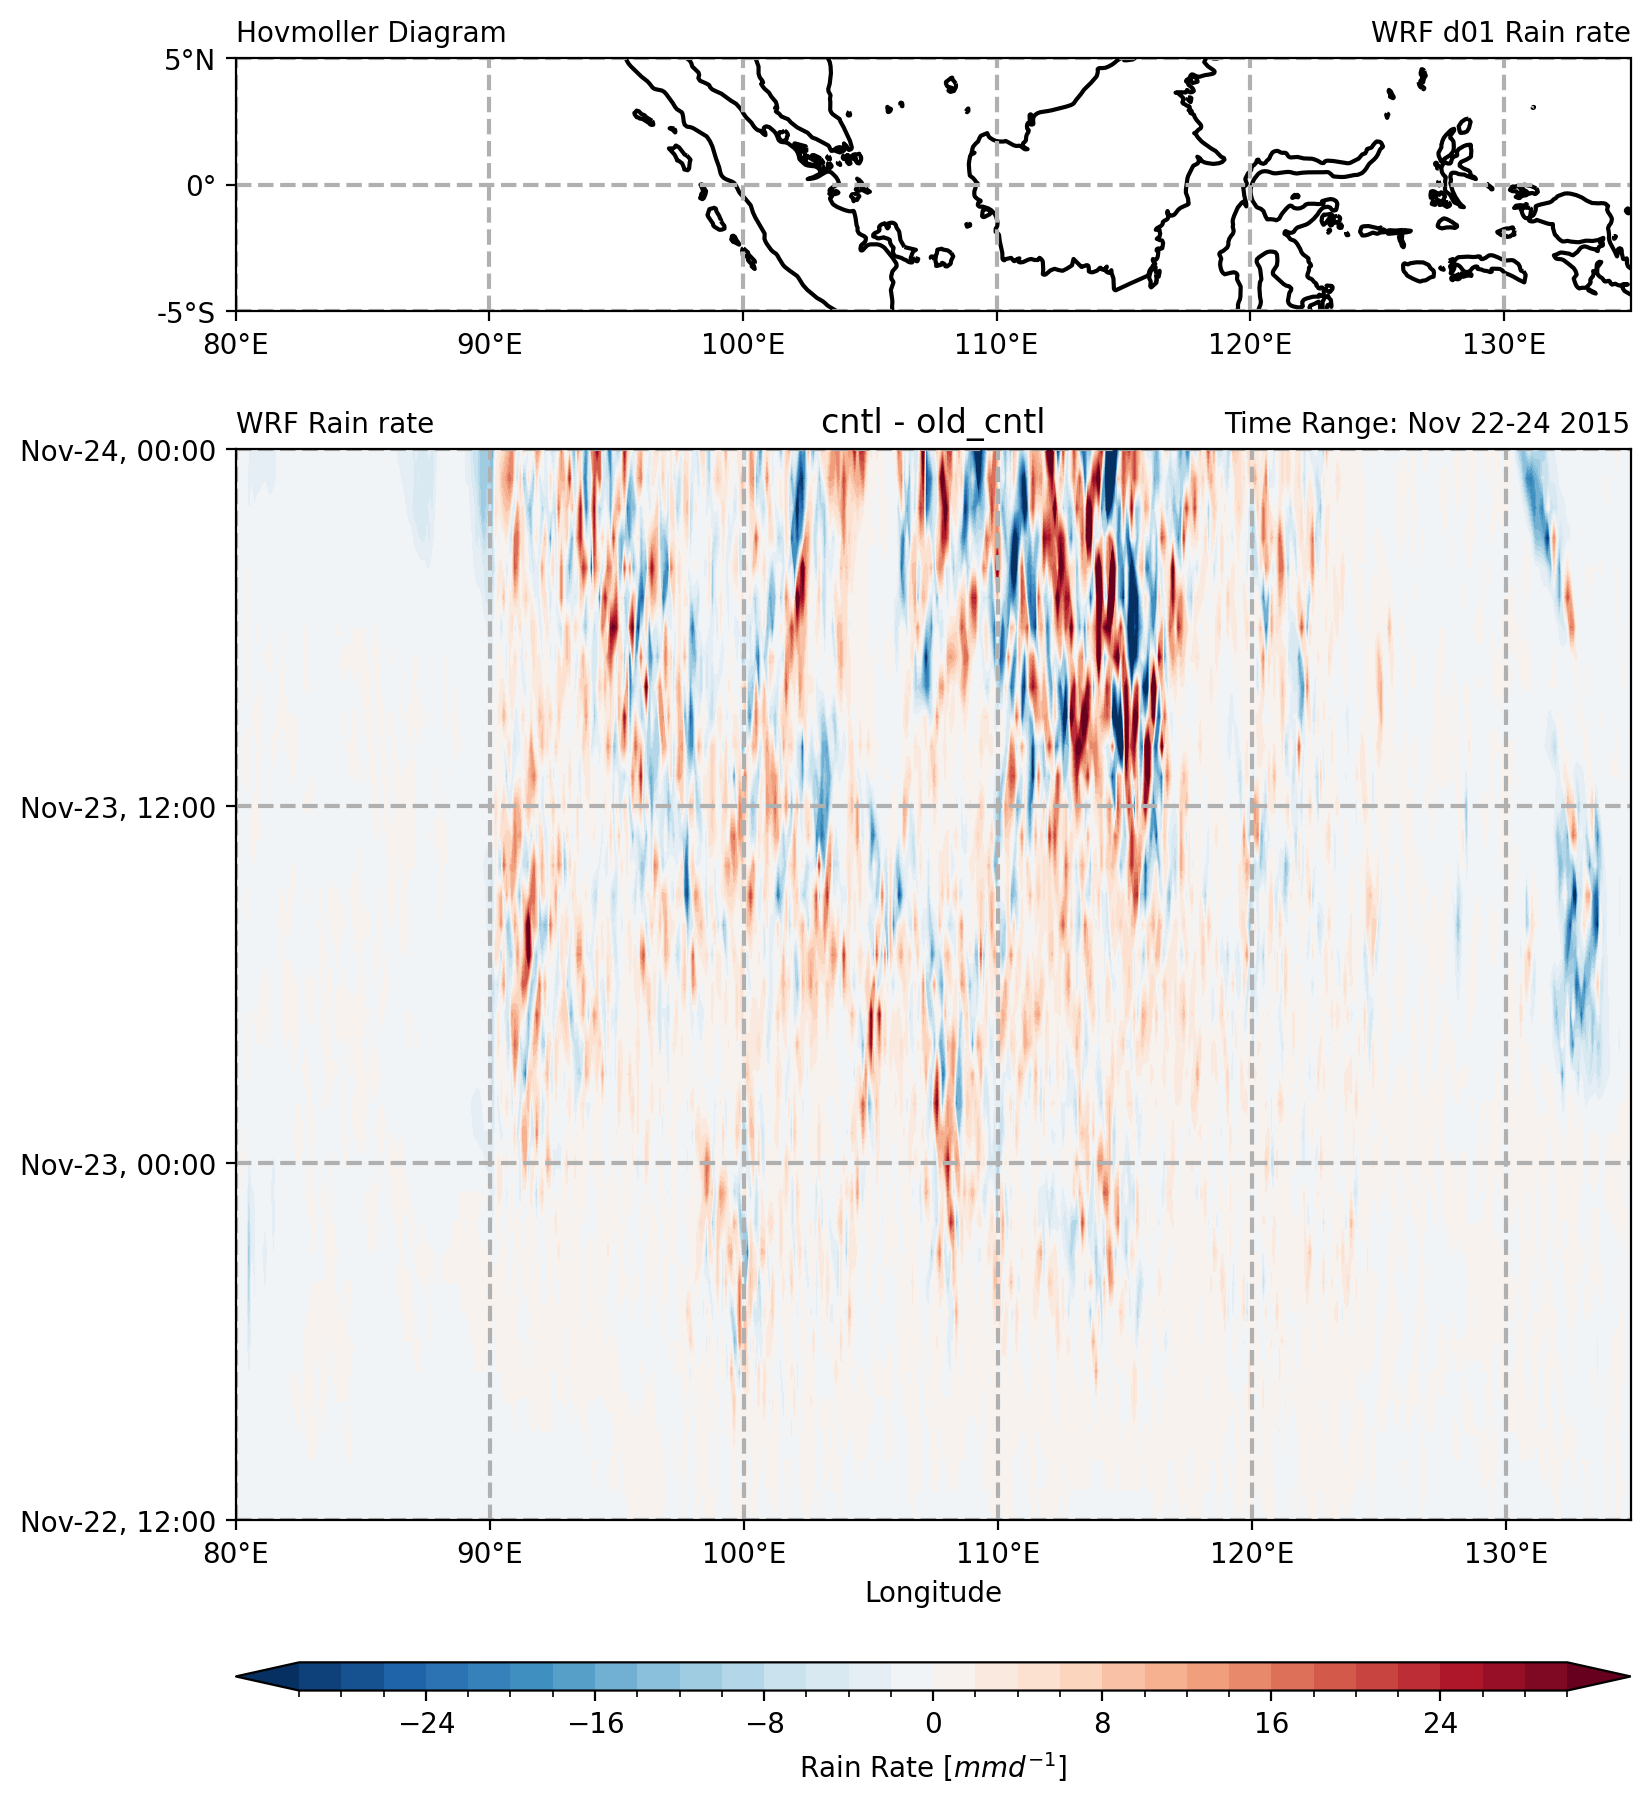

In [32]:
#######################################################################
################## Top plot for Hovmoller diagram #####################
#######################################################################

fig = plt.figure(figsize=(9,11))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=5, ncols=2, hspace=0.075, height_ratios=[0.20,0.015,0.57,0.05,0.015])

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([lon_bound_d01[0], lon_bound_d01[1], lat_bound[0], lat_bound[1]], ccrs.PlateCarree(central_longitude=0))
# Tick labels
ax1.set_yticks([-5, 0, 5])
ax1.set_yticklabels([u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N'])

# ax1.set_yticks([-10, -5, 0, 5, 10])
# ax1.set_yticklabels([u'-10\N{DEGREE SIGN}S', u'-5\N{DEGREE SIGN}S', u'0\N{DEGREE SIGN}', u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N'])
x_ticks = np.array([80,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E',u'130\N{DEGREE SIGN}E']
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='--', linewidth=1.5)
# Plot the coast lines
ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

# Set titles
plt.title('Hovmoller Diagram', loc='left', fontsize=10)
plt.title('WRF d01 Rain rate', loc='right', fontsize=10)

#######################################################################
################## Bottom plot for Hovmoller diagram ##################
#######################################################################


## Preparing data to be plotted
lat_avg_bound = [-5,5]

# Isolate and average the rain rates between the lat_avg_bounds and make rain rate into [mm/day]
# Take the anomalies compared to the old control i.e., cntl - old_cntl
x1 = da_d01_RR_cntl.where(
    (da_d01_RR_cntl.XLAT>lat_avg_bound[0]) & (da_d01_RR_cntl.XLAT<lat_avg_bound[1]),
    drop=True).mean('south_north')*24 - da_d01_RR_oldcntl[0:37,...].where(
		(da_d01_RR_oldcntl[0:37,...].XLAT>lat_avg_bound[0]) & (da_d01_RR_oldcntl[0:37,...].XLAT<lat_avg_bound[1]),
		drop=True).mean('south_north')*24 

# Create a meta data point for rain rate that matches the Longitude
x1 = x1.assign_coords(west_east=(['west_east'],ds_d01.XLONG.values[0,0,:]))
x1 = x1.set_index(Time='XTIME')

ax2 = fig.add_subplot(gs[2, :]) # ax2.invert_yaxis()

# Plot the rain rates
cf2 = x1.plot.contourf(
    # x = 'west_east',
    # y = 'Time',
	ax=ax2,
	add_colorbar=False,
	xticks=x_ticks,
	cmap='RdBu_r',
	levels=np.arange(-30,32,2),
	# levels=np.append(0,np.logspace(0,2,15)),
	vmin=-30, vmax=30
	# extend='max'
)

# Create grids
ax2.grid(linestyle='--', axis='x', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbars
	# Rain rate colorbar
ax4 = fig.add_subplot(gs[4, :])
cbar2 = plt.colorbar(cf2, cax=ax4, orientation='horizontal', pad=0.5, aspect=100, extend='max')
cbar2.set_label('Rain Rate [$mm d^{-1}$]')

# Set titles/labels
ax2.set_title('WRF Rain rate', loc='left', fontsize=10)
ax2.set_title('Time Range: Nov 22-24 2015', loc='right', fontsize=10)
ax2.set_title('cntl - old_cntl', loc='center')

ax2.set_xticklabels(x_tick_labels)
t = x1.Time[0::12].dt.strftime("%b-%d, %H:%M")
ax2.set_yticks(x1.Time[0::12])
ax2.set_yticklabels(t.values)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('')

### Diurnal Composites

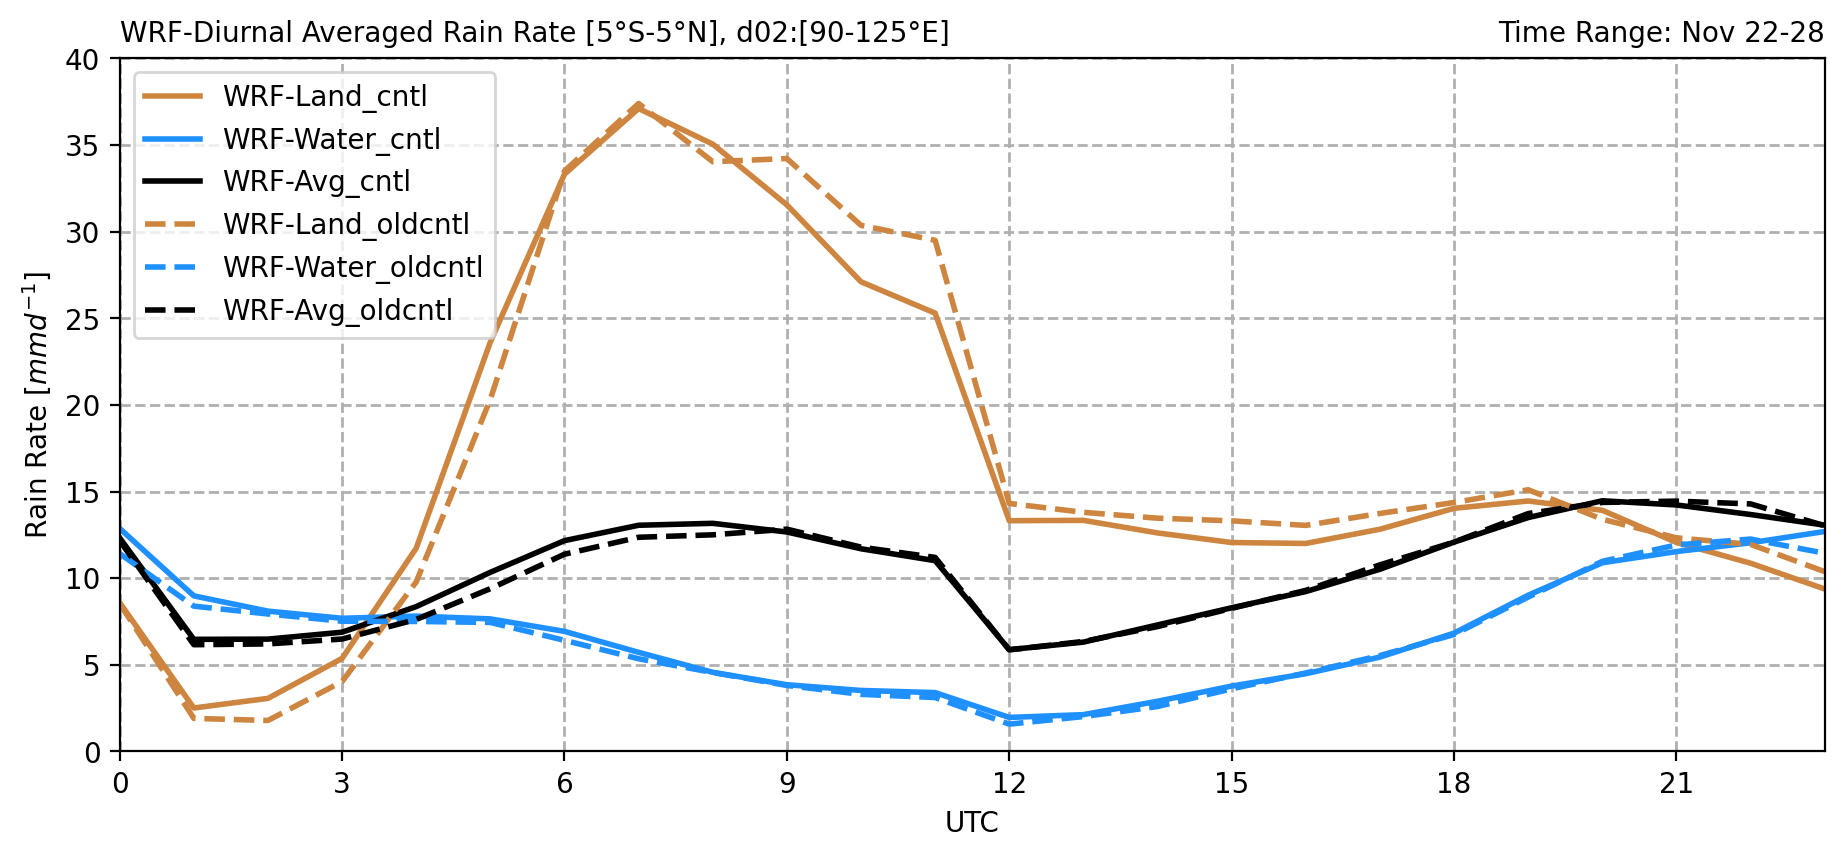

In [52]:
######## Old Control ########

# Uses the same d02 domain box for all
x = da_d01_RR_oldcntl[0:37,...]
#################### d01 ####################
da = x.where((x.XLAT>lat_bound[0])&(x.XLAT<lat_bound[1])
		     &(x.XLONG>lon_bound_d01[0])&(x.XLONG<lon_bound_d01[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1L_oldcntl = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1W_oldcntl = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1A_oldcntl = da_avg.groupby('Time.hour').mean()

x = da_d02_RR_oldcntl[0:37,...]
#################### d02 ####################
da = x.where((x.XLAT>lat_bound[0])&(x.XLAT<lat_bound[1])
		     &(x.XLONG>lon_bound_d02[0])&(x.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2L_oldcntl = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2W_oldcntl = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2A_oldcntl = da_avg.groupby('Time.hour').mean()


######## Control ########

# Uses the same d02 domain box for all
#################### d01 ####################
da = da_d01_RR_cntl.where((da_d01_RR_cntl.XLAT>lat_bound[0])&(da_d01_RR_cntl.XLAT<lat_bound[1])
		     &(da_d01_RR_cntl.XLONG>lon_bound_d01[0])&(da_d01_RR_cntl.XLONG<lon_bound_d01[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1L_cntl = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1W_cntl = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x1A_cntl = da_avg.groupby('Time.hour').mean()

#################### d02 ####################
da = da_d02_RR_cntl.where((da_d02_RR_cntl.XLAT>lat_bound[0])&(da_d02_RR_cntl.XLAT<lat_bound[1])
		     &(da_d02_RR_cntl.XLONG>lon_bound_d02[0])&(da_d02_RR_cntl.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
da_avg = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2L_cntl = da_avg.groupby('Time.hour').mean()

########## Water ##########
da_avg = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2W_cntl = da_avg.groupby('Time.hour').mean()

########## Avg ##########
da_avg = da.mean('south_north').mean('west_east')
da_avg = da_avg.assign_coords(Time=(['Time'],da.XTIME.values))
x2A_cntl = da_avg.groupby('Time.hour').mean()

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x2L_cntl.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='WRF-Land_cntl'
)
b = x2W_cntl.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='WRF-Water_cntl'
)
c = x2A_cntl.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='k',
    linewidth=2,
    linestyle = '-',
	label='WRF-Avg_cntl'
)

d = x2L_oldcntl.plot.line(
    ax=ax1,
    xlim=[0,23],
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='WRF-Land_oldcntl'
)
e = x2W_oldcntl.plot.line(
    ax=ax1,
    xlim=[0,23],
    ylim=[0,40],
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='WRF-Water_oldcntl'
)
f = x2A_oldcntl.plot.line(
    ax=ax1,
    xlim=[0,23],
    ylim=[0,40],
    color='k',
    linewidth=2,
    linestyle = '--',
	label='WRF-Avg_oldcntl'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
# ax1.set_title('WRF-Diurnal Averaged Rain Rate [5°S-5°N], d01 & d02:[90°-125°E]', loc='left', fontsize=10)
ax1.set_title('WRF-Diurnal Averaged Rain Rate [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22-28', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(np.arange(0,24,3))
# ax2.set_yticklabels(t.values)
ax1.set_xlabel('UTC')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.legend(loc='upper left')


### Time Evolutions

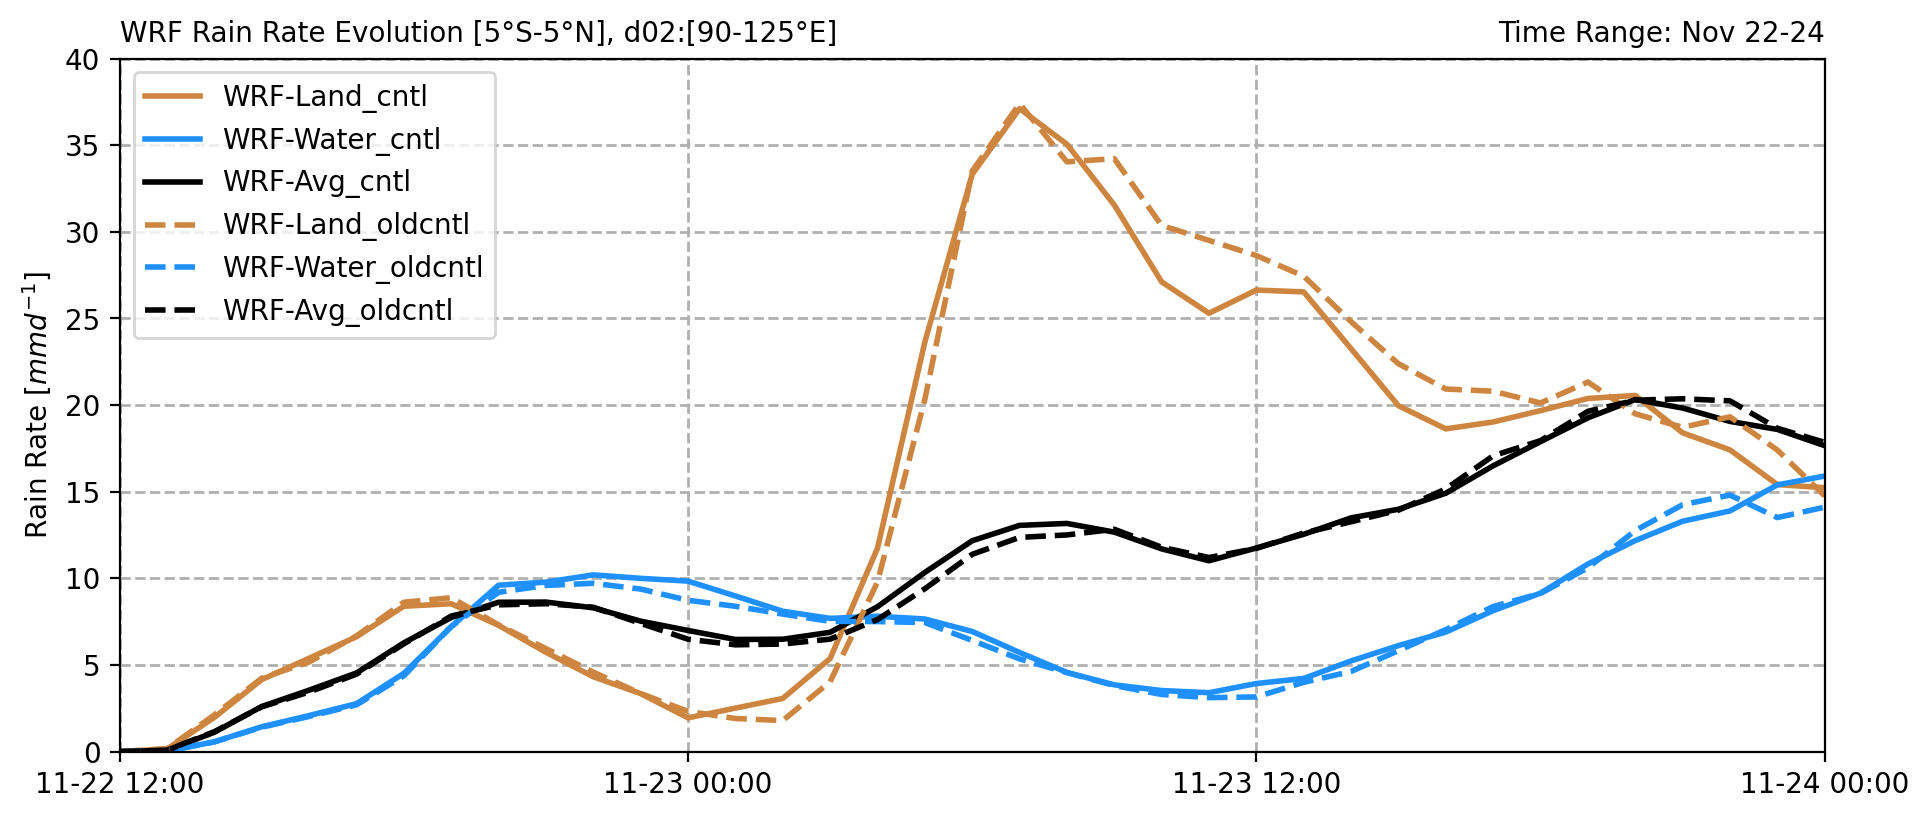

In [70]:
######## Old Control ########

# Uses the same d02 domain box for all
x = da_d01_RR_oldcntl[0:37,...]
#################### d01 ####################
da = x.where((x.XLAT>lat_bound[0])&(x.XLAT<lat_bound[1])
		     &(x.XLONG>lon_bound_d01[0])&(x.XLONG<lon_bound_d01[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
x1L_oldcntl = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
x1L_oldcntl = x1L_oldcntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Water ##########
x1W_oldcntl = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
x1W_oldcntl = x1W_oldcntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Avg ##########
x1A_oldcntl = da.mean('south_north').mean('west_east')
x1A_oldcntl = x1A_oldcntl.assign_coords(Time=(['Time'],da.XTIME.values))

x = da_d02_RR_oldcntl[0:37,...]
#################### d02 ####################
da = x.where((x.XLAT>lat_bound[0])&(x.XLAT<lat_bound[1])
		     &(x.XLONG>lon_bound_d02[0])&(x.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
x2L_oldcntl = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
x2L_oldcntl = x2L_oldcntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Water ##########
x2W_oldcntl = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
x2W_oldcntl = x2W_oldcntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Avg ##########
x2A_oldcntl = da.mean('south_north').mean('west_east')
x2A_oldcntl = x2A_oldcntl.assign_coords(Time=(['Time'],da.XTIME.values))


######## Control ########

# Uses the same d02 domain box for all
#################### d01 ####################
da = da_d01_RR_cntl.where((da_d01_RR_cntl.XLAT>lat_bound[0])&(da_d01_RR_cntl.XLAT<lat_bound[1])
		     &(da_d01_RR_cntl.XLONG>lon_bound_d01[0])&(da_d01_RR_cntl.XLONG<lon_bound_d01[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
x1L_cntl = da.where(da_d01_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
x1L_cntl = x1L_cntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Water ##########
x1W_cntl = da.where(da_d01_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
x1W_cntl = x1W_cntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Avg ##########
x1A_cntl = da.mean('south_north').mean('west_east')
x1A_cntl = x1A_cntl.assign_coords(Time=(['Time'],da.XTIME.values))

#################### d02 ####################
da = da_d02_RR_cntl.where((da_d02_RR_cntl.XLAT>lat_bound[0])&(da_d02_RR_cntl.XLAT<lat_bound[1])
		     &(da_d02_RR_cntl.XLONG>lon_bound_d02[0])&(da_d02_RR_cntl.XLONG<lon_bound_d02[1]),drop=False)*24
# LANDMASK (land = 1, water = 0)
########## Land ##########
x2L_cntl = da.where(da_d02_LANDMASK==1,drop=False).mean('south_north').mean('west_east')
x2L_cntl = x2L_cntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Water ##########
x2W_cntl = da.where(da_d02_LANDMASK==0,drop=False).mean('south_north').mean('west_east')
x2W_cntl = x2W_cntl.assign_coords(Time=(['Time'],da.XTIME.values))

########## Avg ##########
x2A_cntl = da.mean('south_north').mean('west_east')
x2A_cntl = x2A_cntl.assign_coords(Time=(['Time'],da.XTIME.values))

#### PLOTTING ####

fig = plt.figure(figsize=(11,4.5))
ax1 = fig.add_subplot()

a = x2L_cntl.plot.line(
    ax=ax1,
    ylim=[0,40],
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='WRF-Land_cntl'
)
b = x2W_cntl.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='WRF-Water_cntl'
)
c = x2A_cntl.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='WRF-Avg_cntl'
)

d = x2L_oldcntl.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='WRF-Land_oldcntl'
)
e = x2W_oldcntl.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='WRF-Water_oldcntl'
)
f = x2A_oldcntl.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='WRF-Avg_oldcntl'
)

ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
# Set titles/labels
ax1.set_title('WRF Rain Rate Evolution [5°S-5°N], d02:[90-125°E]', loc='left', fontsize=10)
ax1.set_title('Time Range: Nov 22-24', loc='right', fontsize=10)
ax1.set_title('')

ax1.set_xticks(x1L_oldcntl.Time[0::12])
ax1.set_xlim(x1L_oldcntl.Time[0],x1L_oldcntl.Time[-1])
ax1.tick_params(rotation=0)
ax1.set_xticklabels(np.array(x1L_oldcntl.Time[0::12].dt.strftime("%m-%d %H:%M")),horizontalalignment='center')
ax1.set_ylabel('Rain Rate [$mm d^{-1}$]')
ax1.set_xlabel('')
ax1.legend(loc='upper left')


### Spatial Maps